In [5]:
# Setting up environment
import psycopg2
import pandas as pd
import numpy as np
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
%matplotlib inline
import seaborn as sns
print("Setup Complete")

Setup Complete


In [6]:
# open connection to database
conn = psycopg2.connect(host='localhost', dbname= 'postgres', user='postgres', password='1q2w3e4r5ttg')
cursor = conn.cursor()

In [7]:
# What are the most expensive tracks ?
track_value = """
    select 
    *
    from (
    select 
        track_id
        , unit_price
        , dense_rank() over(partition by unit_price order by unit_price desc) as ranking_preco
    from 
        dw_chinook.fact_transaction
    ) base
    where
        ranking_preco <> 1
"""
df_track_value = pd.read_sql_query(track_value, conn)
df_track_value
# This query returns a empty dataframe which means all tracks are sold with the same price (0.99).

,track_id,unit_price,ranking_preco


In [8]:
# extracting a dataframe with revenue and quantity of units sold per track per year
tracks_year = """
	select 
		base.*
		, track
		, artist
	from (
	select 
		track_id
		,sum(total) as revenue
		,sum(quantity) as units_sold
		,extract(year from date) as year
	from dw_chinook.fact_transaction
	group by track_id, year
	) base
	join 
		dw_chinook.dim_track on base.track_id = dim_track.track_id 
"""
df_tracks_year = pd.read_sql_query(tracks_year, conn)


In [9]:
# extracting a dataframe with the top 30 tracks based on revenue and units_sold.
tracks_list = """
	select 
		base.track_id
	from (
	select 
		track_id
		,sum(total) as revenue
		,sum(quantity) as units_solds
	from dw_chinook.fact_transaction
	group by track_id 
	) base
	join 
		dw_chinook.dim_track on base.track_id = dim_track.track_id 
	order by revenue desc 
	limit 10
"""
df_tracks_list = pd.read_sql_query(tracks_list, conn)
df_tracks_list.count()


track_id    10
dtype: int64

In [10]:
df_tracks = pd.merge(df_tracks_year, df_tracks_list, on='track_id', how='inner').sort_values(by=['revenue'], ascending=False)

In [11]:
# extracting a dataframe with revenue and quantity of units sold per artist per year
artists_year = """
    select 
        base.*
    from (
    select 
        artist
        ,sum(total) as revenue
        ,sum(quantity) as units_solds
        ,extract(year from date) as year
    from dw_chinook.fact_transaction
    join 
        dw_chinook.dim_track on fact_transaction.track_id = dim_track.track_id 
    group by artist, year
    ) base
"""
df_artists_year= pd.read_sql_query(artists_year, conn)
#df_artists_revenue.head(15)

In [12]:
# What are the 15 artists that have the most unit labels sold ?
artists_list = """
    select 
        artist
    from (
    select 
        artist
        ,sum(total) as revenue
        ,sum(quantity) as units_solds
    from dw_chinook.fact_transaction
    join 
        dw_chinook.dim_track on fact_transaction.track_id = dim_track.track_id 
    group by artist
    ) base
    order by revenue desc
    limit 10
"""
df_artists_list = pd.read_sql_query(artists_list, conn)
#df_artists_units.head(15)

In [13]:
df_artists = pd.merge(df_artists_year, df_artists_list, on='artist', how='inner').sort_values(by=['revenue'], ascending=False)
#df_artists.count()

#### **Two dataframes was generated, so far:**
* *df_tracks*
* *df_artists*
---
**Now lets see if the correlation between revenue and units sold is significant as expect and explore other charts**

Text(0.5, 1.0, 'Correlation Heatmap Between Variable')

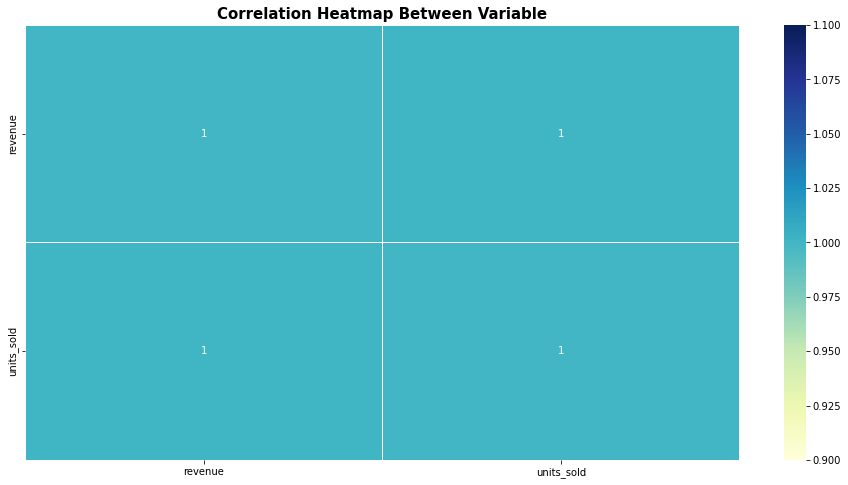

In [14]:
# first for tracks

plt.figure(figsize=(16,8))
corr_df_tracks=df_tracks.drop(['track_id', 'year'], axis=1).corr(method='pearson')
heatmap=sns.heatmap(corr_df_tracks, annot=True, fmt='.2g', cmap='YlGnBu', linewidths=.5)
heatmap.set_title('Correlation Heatmap Between Variable', fontsize=15, fontweight='bold')

Text(0.5, 1.0, 'Correlation Heatmap Between Variable')

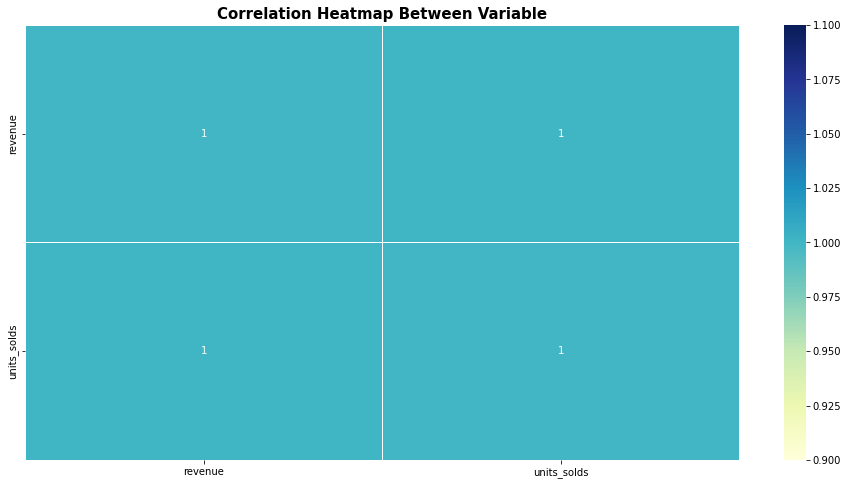

In [15]:
# Now for the artists
plt.figure(figsize=(16,8))
corr_df_artist=df_artists.drop(['artist', 'year'], axis=1).corr(method='pearson')
heatmap=sns.heatmap(corr_df_artist, annot=True, fmt='.2g', cmap='YlGnBu', linewidths=.5)
heatmap.set_title('Correlation Heatmap Between Variable', fontsize=15, fontweight='bold')

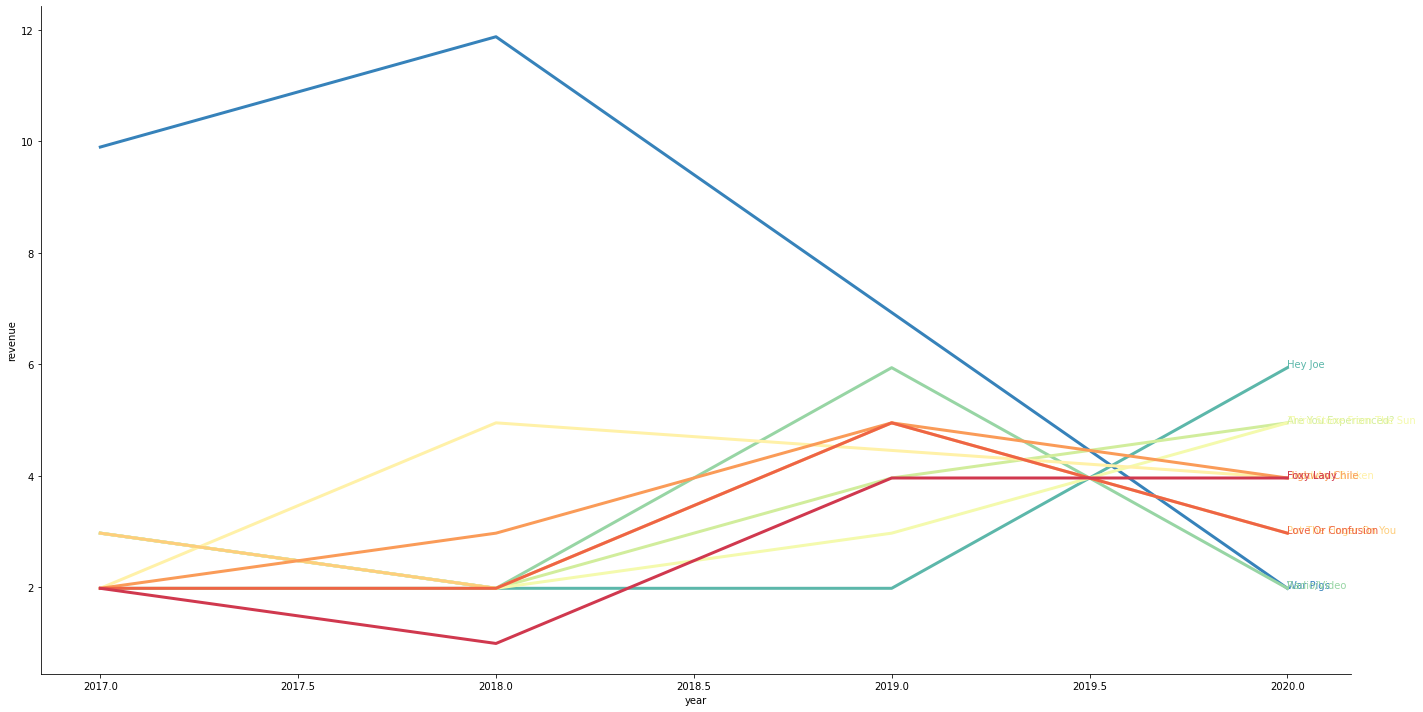

In [23]:
# Line chart for tracks
# The line chart shows the revenue per year for the top 10 tracks in the dataframe.
# It can give us an idea of the trend in the revenue per year.

# Make a plot
fig, ax = plt.subplots(figsize=(20,10))

# Add lines to it
sns.lineplot(ax=ax, data=df_tracks, x='year', y='revenue', hue='track', legend=False, linewidth=3, palette='Spectral_r')
sns.despine()

# Add the text --for each line, find the end, annotate it with a label, and
# adjust the chart axes so that everything fits on.
for line, name in zip(ax.lines, df_tracks.track.unique().tolist()):
	y = line.get_ydata()[-1]
	x = line.get_xdata()[-1]
#	if not np.isfinite(y):
#	    y=next(reversed(line.get_ydata()[~line.get_ydata().mask]),float("nan"))
#	if not np.isfinite(y) or not np.isfinite(x):
#	    continue
	text = ax.annotate(name,
			xy=(x, y),
			xytext=(0, 0),
			color=line.get_color(),
			xycoords=(ax.get_xaxis_transform(),
				ax.get_yaxis_transform()),
			textcoords="offset points")
	text_width = (text.get_window_extent(
	fig.canvas.get_renderer()).transformed(ax.transData.inverted()).width)
	if np.isfinite(text_width):
		ax.set_xlim(ax.get_xlim()[0], text.xy[0] + text_width * 1.05)

# Format the date axis to be prettier.
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
#ax.xaxis.set_minor_locator(mdates.DayLocator())
#ax.xaxis.set_major_locator(mdates.AutoDateLocator(interval_multiples=False))
plt.tight_layout()
plt.show()

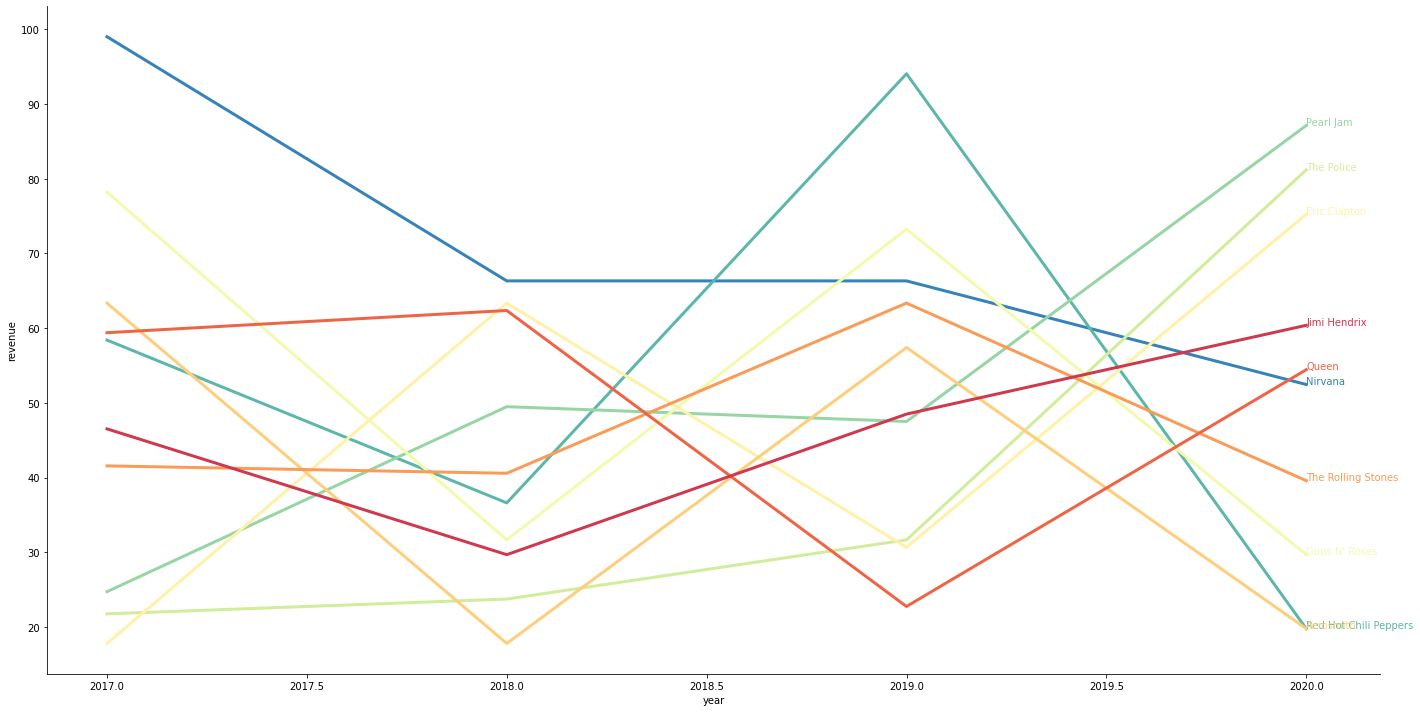

In [22]:
# Line chart for artists
# The line chart shows the revenue per year for the top 10 artists in the dataframe.
# It can give us an idea of the trend in the revenue per year.

# Make a plot
fig, ax = plt.subplots(figsize=(20,10))

# Add lines to it
sns.lineplot(ax=ax, data=df_artists, x='year', y='revenue', hue='artist', legend=False, linewidth=3, palette='Spectral_r')
sns.despine()

# Add the text --for each line, find the end, annotate it with a label, and
# adjust the chart axes so that everything fits on.
for line, name in zip(ax.lines, df_artists.artist.unique().tolist()):
	y = line.get_ydata()[-1]
	x = line.get_xdata()[-1]
#	if not np.isfinite(y):
#	    y=next(reversed(line.get_ydata()[~line.get_ydata().mask]),float("nan"))
#	if not np.isfinite(y) or not np.isfinite(x):
#	    continue
	text = ax.annotate(name,
			xy=(x, y),
			xytext=(0, 0),
			color=line.get_color(),
			xycoords=(ax.get_xaxis_transform(),
				ax.get_yaxis_transform()),
			textcoords="offset points")
	text_width = (text.get_window_extent(
	fig.canvas.get_renderer()).transformed(ax.transData.inverted()).width)
	if np.isfinite(text_width):
		ax.set_xlim(ax.get_xlim()[0], text.xy[0] + text_width * 1.05)

# Format the date axis to be prettier.
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
#ax.xaxis.set_minor_locator(mdates.DayLocator())
#ax.xaxis.set_major_locator(mdates.AutoDateLocator(interval_multiples=False))

plt.tight_layout()
plt.show()


#### **But how find the most trends artists and musics and the whole dataset ?**
**We can create a new column that represents the *DELTA* between revenue of previus year and next year**

In [18]:
artists_total_trend = """
    with base as (
    select 
        *
    from (
        select 
            artist
            ,sum(total) as revenue
            ,sum(quantity) as units_solds
            ,extract(year from date) as year
        from dw_chinook.fact_transaction
        join 
            dw_chinook.dim_track on fact_transaction.track_id = dim_track.track_id 
        group by artist, year
        ) per_year
    ), 
    diff as (
    select 
        *
        ,revenue - lag(revenue) over(partition by artist order by year) as improvement
    from 
        base
    )
    select 
        *
    from 
        diff
    where year = 2020 and improvement >0
    order by improvement desc
"""
df_artists_trend = pd.read_sql_query(artists_total_trend, conn)
df_artists_trend.head(15)

,artist,revenue,units_solds,year,improvement
0,The Police,81.18,82,2020.0,49.50
1,Eric Clapton,75.24,76,2020.0,44.55
2,Pearl Jam,87.12,88,2020.0,39.60
3,Queen,54.45,55,2020.0,31.68
4,Godsmack,39.60,40,2020.0,28.71
5,Chris Cornell,33.66,34,2020.0,27.72
6,Skank,25.74,26,2020.0,24.75
7,Amy Winehouse,34.65,35,2020.0,22.77
8,Miles Davis,25.74,26,2020.0,20.79
9,Marisa Monte,18.81,19,2020.0,17.82


In [19]:
tracks_total_trend = """
    with base as (
    select 
        *
    from (
        select 
            fact_transaction.track_id
            , track
            , artist
            ,sum(total) as revenue
            ,sum(quantity) as units_solds
            ,extract(year from date) as year
        from dw_chinook.fact_transaction
        join 
            dw_chinook.dim_track on fact_transaction.track_id = dim_track.track_id 
        group by fact_transaction.track_id, year, track, artist
        ) per_year
    ), 
    diff as (
    select 
        *
        ,revenue - lag(revenue) over(partition by track_id order by year) as improvement
    from 
        base
    )
    select 
        *
    from 
        diff
    where year = 2020 and improvement >0
    order by improvement desc
"""
df_tracks_trend = pd.read_sql_query(tracks_total_trend, conn)
df_tracks_trend.head(15)

,track_id,track,artist,revenue,units_solds,year,improvement
0,2662,Don't Stand So Close to Me '86,The Police,9.90,10,2020.0,7.92
1,2651,Can't Stand Losing You,The Police,9.90,10,2020.0,7.92
2,2652,Message in a Bottle,The Police,7.92,8,2020.0,5.94
3,152,N.I.B.,Black Sabbath,5.94,6,2020.0,3.96
4,2655,"De Do Do Do, De Da Da Da",The Police,7.92,8,2020.0,3.96
5,3473,Take the Box,Amy Winehouse,4.95,5,2020.0,3.96
6,2603,Hitsville UK,The Clash,5.94,6,2020.0,3.96
7,2657,Invisible Sun,The Police,5.94,6,2020.0,3.96
8,3424,"Turandot, Act III, Nessun dorma!",Luciano Pavarotti,11.88,12,2020.0,3.96
9,1490,Hey Joe,Jimi Hendrix,5.94,6,2020.0,3.96


In [20]:
# close connection to database
conn.close()

In [21]:
#Same as before but just manipuling data with pandas
'''
df_artists['improvement'] = df_artists['revenue']-df_artists.sort_values(by=['year'], ascending=True).groupby('artist')['revenue'].shift(1)
df_artists_trends = df_artists.loc[df_artists['year']==2020].loc[df_artists['improvement']>0].sort_values(by=['improvement', 'revenue'], ascending=False)

df_tracks['improvement'] = df_tracks['revenue']-df_tracks.sort_values(by=['year'], ascending=True).groupby('track_id')['revenue'].shift(1)
df_tracks_trends = df_tracks.loc[df_tracks['year']==2020].loc[df_tracks['improvement']>0].sort_values(by=['improvement', 'revenue'], ascending=False)
'''

"\ndf_artists['improvement'] = df_artists['revenue']-df_artists.sort_values(by=['year'], ascending=True).groupby('artist')['revenue'].shift(1)\ndf_artists_trends = df_artists.loc[df_artists['year']==2020].loc[df_artists['improvement']>0].sort_values(by=['improvement', 'revenue'], ascending=False)\n\ndf_tracks['improvement'] = df_tracks['revenue']-df_tracks.sort_values(by=['year'], ascending=True).groupby('track_id')['revenue'].shift(1)\ndf_tracks_trends = df_tracks.loc[df_tracks['year']==2020].loc[df_tracks['improvement']>0].sort_values(by=['improvement', 'revenue'], ascending=False)\n"